In [3]:
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(ggrastr))
suppressPackageStartupMessages(library(scran))

######################
## Define arguments ##
######################

# p <- ArgumentParser(description='')
# p$add_argument('--sce',             type="character",                               help='SingleCellExperiment file')
# p$add_argument('--metadata',        type="character",                               help='Cell metadata file')
# p$add_argument('--stage',           type="character",                               help='Stages to include')
# p$add_argument('--tdTom_corr',      type="character",                                 help='Keep tdTom+ cells in WT samples (otherwise removed)')
#p$add_argument('--method',          type="character",                               help='Method to use for DEGs, options: singlecell, pseudobulk, pseudobulkreplicates (pseudobulk with replicates from within each sample)')
# p$add_argument('--outdir',          type="character",                               help='Output file')

# args <- p$parse_args(commandArgs(TRUE))

#####################
## Define settings ##
#####################
here::i_am("processing/1_create_seurat_rna.R")
source(here::here("settings.R"))
source(here::here("utils.R"))
source(here::here("mapping/run/mnn/mapping_functions.R"))
test = TRUE

if(test){
## START TEST ##
    args = list()
args$sce <- io$rna.sce
args$metadata <- io$metadata
args$stage <- c('E9.5')#, 'E8.5', 'E9.5')
args$metadata <- paste0(io$basedir,"/results/rna/mapping/sample_metadata_after_mapping.txt.gz")
args$tdTom_corr = 'False'
args$method = 'single_cell'
args$outdir <- paste0(io$basedir,"/results/rna/differential/test")
## END TEST ##
}

# If passing multiple timepoints split in vector
args$stage = strsplit(args$stage, "_")[[1]] 

dir.create(args$outdir, recursive=TRUE, showWarnings = FALSE)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/code



In [129]:
# Plotting function
gg_volcano_plot <- function(celltype_i='Allantois', top_genes=20, xlim=5, ylim=40, label_groups = NULL) {
  to.plot = de.results[celltype == celltype_i]
  negative_hits <- to.plot[sig==TRUE & logFC<0,gene]
  positive_hits <- to.plot[sig==TRUE & logFC>0,gene]
  all <- nrow(to.plot[!is.na(sig)])
  to.plot = to.plot[,logFC_plot:=ifelse(logFC<=-xlim, -xlim, ifelse(logFC>=xlim, xlim, logFC))] %>%
               .[,log10_padj_fdr:=ifelse(-log10(padj_fdr)>=ylim, ylim, -log10(padj_fdr))]
  
  # if (is.null(xlim))
  #   xlim <- max(abs(to.plot$logFC), na.rm=T)
  # if (is.null(ylim))
  #   ylim <- max(-log10(to.plot$padj_fdr+1e-100), na.rm=T)
  
  to.plot <- to.plot[!is.na(logFC) & !is.na(padj_fdr)] %>% .[order(-abs(logFC))]
  label_genes = c(head(to.plot[sig==T & logFC<=0, gene],n=top_genes), head(to.plot[sig==T & logFC>=0, gene],n=top_genes))
  
  p <- ggplot(to.plot, aes(x=logFC_plot, y=log10_padj_fdr)) +
    labs(x="Log fold change", y=expression(paste("-log"[10],"(q.value)"))) +
    ggrastr::geom_point_rast(aes(color=sig, size=sig)) +
    # geom_hline(yintercept = -log10(opts$threshold_fdr), color="blue") +
    geom_segment(aes(x=0, xend=0, y=0, yend=ylim*1.05), color="orange", size=0.5) +
    scale_color_manual(values=c("black","red")) +
    scale_size_manual(values=c(0.5,1)) +
    scale_x_continuous(limits=c(-xlim,xlim)) +
    scale_y_continuous(limits=c(0,ylim*1.16)) +
    annotate("text", x=0, y=ylim*1.1, size=6, label=sprintf("(%d)", all)) +
    annotate("text", x=-xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (-)",length(negative_hits))) +
    annotate("text", x=xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (+)",length(positive_hits))) +
    ggrepel::geom_text_repel(data=to.plot[gene %in% label_genes],
                                    aes(x=logFC_plot, y=log10_padj_fdr, label=gene), max.overlaps=Inf, size=5) +
    theme_classic() +
    theme(
       axis.text = element_text(color='black'),
      # axis.title = element_text(size=rel(1.0), color='black'),
      text=element_text(size=15),
      legend.position="none"
    ) + 
    ggtitle(celltype_i)
  
  
  if (length(label_groups)>0) {
    p <- p +
      annotate("text", x=-4, y=0, size=4, label=sprintf("Up in %s",label_groups[2])) +
      annotate("text", x=4, y=0, size=4, label=sprintf("Up in %s",label_groups[1]))
  }
  
  return(p)
}

# Single cell DEG function

doDiffExpr <- function(sce, groups, min_detection_rate_per_group = 0.15) {
    
  # Sanity checks
  if (!is(sce, "SingleCellExperiment")) stop("'sce' has to be an instance of SingleCellExperiment")
  stopifnot(length(groups)==2)

  # Filter genes by detection rate per group
  cdr_A <- rowMeans(counts(sce[,sce$tdTom_corr==groups[1]])>0) >= min_detection_rate_per_group
  cdr_B <- rowMeans(counts(sce[,sce$tdTom_corr==groups[2]])>0) >= min_detection_rate_per_group
  out <- .edgeR(sce[cdr_B | cdr_A,]) %>% .[,log_padj_fdr:= -log10(padj_fdr)]
  
  return(out)
}


.edgeR <- function(sce) {
  
  # Convert SCE to DGEList
  
  sce_edger <- scran::convertTo(sce, type="edgeR")
 # sce_edger$samples$norm.factors = sce_edger$samples$sizeFactor
    
  # Define design matrix (with intercept)
  #cdr <- colMeans(logcounts(sce)>0)
  # if overlap in pools between KO and WT, use pool in model
  meta = as.data.table(colData(sce))
  if(length(intersect(unique(meta[tdTom_corr==TRUE,pool]), unique(meta[tdTom_corr==FALSE,pool])))>0 &
        length(unique(meta$pool))>1){
      design <- model.matrix(~sce$pool+sce$tdTom_corr)
  }else{
      design <- model.matrix(~sce$tdTom_corr)
  }
  # Estimate dispersions
  sce_edger  <- estimateDisp(sce_edger,design)
  
  # Fit GLM
  fit <- glmQLFit(sce_edger,design)
  
  # Likelihood ratio test
  lrt <- glmQLFTest(fit)
  
  # Construct output data.frame
  out <- topTags(lrt, n=nrow(lrt))$table %>% as.data.table(keep.rownames=T) %>%
    setnames(c("gene","logFC","logCPM","LR","p.value","padj_fdr")) %>%
    .[,c("logCPM","LR"):=NULL]
  
  return(out)
}


In [130]:
##########################
## Load sample metadata ##
##########################

sample_metadata <- fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_call==FALSE & stage %in% args$stage] %>%
    .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)]


if(args$tdTom_corr!='True'){
    sample_metadata = sample_metadata[tdTom==tdTom_corr]
}

# if(test){
#     sample_metadata = sample_metadata[sample(1:nrow(sample_metadata), nrow(sample_metadata)/4)]
# }

###############
## Load data ##
###############

# Load RNA expression data as SingleCellExperiment object
sce <- load_SingleCellExperiment(args$sce, cells=sample_metadata$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce) <- sample_metadata %>% tibble::column_to_rownames("cell") %>% DataFrame

In [131]:
###################
## exclude genes ##
###################

# haemoglobin genes show up as differential expressed in all cell-types when there is a differential abundance in erythroids
# We hypothesise this is due to bursting of the erythroids, resulting in large amount of ambient haemoglobin RNA.
gene_biomart = fread('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/Mmusculus_genes_BioMart.87.txt')
all_genes = gene_biomart$symbol
haem_genes = all_genes[c(grep('Hba', all_genes),
                         grep('Hbb', all_genes))]

# Genes on the y-chr can be differential due to the injected ESC being male, while the host can be either male or female
y_genes = gene_biomart[chr=='chrY', symbol]

# Some genes on the x-chr can be differential for the same reason
# Xist and Tsix are known to often be differentially expressed 
x_genes = c('Xist', 'Tsix')

# Additionally there are some paternally or maternally expressed genes to remove
imprint = gene_biomart[c(grep('maternally', gene_biomart$description),
                       grep('paternally', gene_biomart$description)), symbol]

# Remove all other genes that are not informative, e.g. mitochondrial/ribosomal/predicted genes etc
non_informative = all_genes[grep("*Rik|^Gm|^mt-|^Rps|^Rpl|^Olfr", all_genes)]

# Genes differential from WT injection experiment
#WT_inj = fread('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/WT_injection/old/tomato_DEGs_edgeR.csv')

# Tomato-td is differentially expressed, because it is only present in the KO cells
excl_genes = intersect(c(haem_genes, y_genes, x_genes, imprint, non_informative, 'tomato-td'), rownames(sce))

In [132]:
sce = sce[!rownames(sce) %in% excl_genes,]

In [12]:
args$method='pseudobulk'

In [19]:
# Pseudobulk 

if(args$method=='pseudobulk'){
    # Using 'celltype' and 'sample' as our two factors; each column of the output
    # corresponds to one unique combination of these two factors.
    summed <- aggregateAcrossCells(sce, 
        id=colData(sce)[,c("celltype.mapped_mnn", "sample", "tdTom_corr")])

    summed.filt <- summed[,summed$ncells >= 15]

    de.results <- pseudoBulkDGE(summed.filt, 
        label=summed.filt$celltype.mapped_mnn,
        design=~factor(pool) + tdTom_corr,
        coef="tdTom_corrTRUE",
        condition=summed.filt$tdTom_corr 
        ) %>% unlist() %>% 
            as.data.table(keep.rownames=T) %>%
            .[,`:=`(gene=str_split(rn, '\\.') %>% map_chr(2), # extract gene names
                    celltype=str_split(rn, '\\.') %>% map_chr(1), # extract cell type
                    rn=NULL, 
                    stage=paste(args$stage, collapse='_'), # add stage
                    sig=ifelse(abs(logFC)>=1 & FDR<=0.05, TRUE, FALSE))] %>%  # significance
            .[!is.na(logFC),] %>%
            setnames('FDR', 'padj_fdr')
    
    # Make plots
    plots = lapply(unique(de.results$celltype),gg_volcano_plot, ylim=20, xlim=5)
}

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [20]:
# Save outputs
fwrite(de.results, file=sprintf('%s/DEresults_stage%s_tdTom_corr%s_%s.txt.gz', args$outdir, paste(args$stage, collapse='_'), args$tdTom_corr, args$method))
pdf(file=sprintf('%s/DEresults_stage%s_tdTom_corr%s_%s.pdf', args$outdir, paste(args$stage, collapse='_'), args$tdTom_corr, args$method), height=8, width=8)
    plots 
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]


png 
  2

In [21]:
args$method='singlecell'

In [24]:
# Single_cell

if(args$method=='singlecell'){
    sce$group = sample_metadata$tdTom_corr
    opts$groups = c(FALSE, TRUE)
    sce$group = factor(sce$group, levels = opts$groups)
        
    de.results = lapply(unique(sample_metadata$celltype.mapped_mnn), function(x){     #unique(meta$celltype.mapped)
        # Only keep cell types with at least 20 cells in both KO and WT
        if(!TRUE %in% as.vector(as.data.frame(table(sample_metadata[celltype.mapped_mnn==x, tdTom_corr]))$Freq<20) & 
           length(unique(sample_metadata[celltype.mapped_mnn==x, tdTom_corr]))==2){
            message(x)
            sce_deg = sce[, sample_metadata$celltype.mapped_mnn==x]
                out <- doDiffExpr(sce_deg, opts$groups) %>%
                  # Add sample statistics
                  .[,c("groupA_N","groupB_N"):=list(table(sce_deg$group)[1],table(sce_deg$group)[2])]%>% 
                  .[,c("groupA","groupB", "celltype"):=list(opts$groups[1],opts$groups[2],x)]%>%  
                  # Calculate statistical significance
                  .[, sig := (padj_fdr<=0.05 & abs(logFC)>=1)] %>%
                  .[is.na(sig),sig:=FALSE] %>% 
                  setorder(-sig, padj_fdr, na.last=T) %>%
                  # Add celltype
                    .[,celltype:=x]

                # Parse columns
                out[,c("p.value","padj_fdr","logFC","log_padj_fdr"):=list(signif(p.value,digits=3), signif(padj_fdr,digits=3), round(logFC,3),round(log_padj_fdr,3))]
                return(out)
                } 
            }) %>% rbindlist()
    
    # Make plots
    plots = lapply(unique(de.results$celltype),gg_volcano_plot, ylim=20, xlim=5)
}
    

Epiblast

Blood progenitors

Lateral plate mesoderm

Node

Limb mesoderm

Ectoderm

Haematoendothelial progenitors

Non-neural ectoderm

Intermediate mesoderm

Caudal epiblast

Paraxial mesoderm

Nascent mesoderm

Allantois

Gut tube

Allantois endothelium

Mesenchyme

Primitive Streak

Neural tube

PGC



In [25]:
# Save outputs
fwrite(de.results, file=sprintf('%s/DEresults_stage%s_tdTom_corr%s_%s.txt.gz', args$outdir, paste(args$stage, collapse='_'), args$tdTom_corr, args$method))
pdf(file=sprintf('%s/DEresults_stage%s_tdTom_corr%s_%s.pdf', args$outdir, paste(args$stage, collapse='_'), args$tdTom_corr, args$method), height=8, width=8)
    plots 
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]

[[19]]


png 
  2

In [80]:
args$method='pseudobulkreplicates'

In [151]:
# Pseudobulk 

if(args$method=='pseudobulkreplicates'){
    suppressPackageStartupMessages(library(parallel))
    # replicates will be made per pool, celltype, and tdTom_corr status
    sample_metadata$group = paste0(sample_metadata$pool, '_', sample_metadata$celltype.mapped_mnn, '_', sample_metadata$tdTom_corr) 
    sce$group = sample_metadata$group

        
    pseudobulk_replicate = mclapply(unique(sample_metadata$group), function(i){
        summed_list = list()
        tmp = sample_metadata[group==i]
        if(nrow(tmp) >= 25){
            message(i)
            for(x in 1:5){
                # sample 50% of cells per pseudoreplicate
                sample = tmp[sample(1:nrow(tmp), size=nrow(tmp)*0.5,  replace = TRUE)]
                sce_tmp = sce[,sample$cell]
                sce_tmp$ncells = nrow(tmp)

                summed_list[[x]] <- aggregateAcrossCells(sce_tmp, id=sce_tmp$group)
                colnames(summed_list[[x]]) = paste0(colnames(summed_list[[x]]), '_rep', x)
                }
            pseudobulk_group = do.call('cbind', summed_list)
            return(pseudobulk_group)
        }
    }, mc.cores=16) 
    pseudobulk_replicate = do.call('cbind', compact(pseudobulk_replicate))
    
    
    pseudo_metadata = as.data.table(colData(pseudobulk_replicate))
    opts$groups = c(FALSE, TRUE)

de.results = lapply(unique(pseudo_metadata$celltype.mapped_mnn, min_detection_rate_per_group=0.4), function(x){     #unique(meta$celltype.mapped)
        sce_deg = pseudobulk_replicate[, pseudo_metadata$celltype.mapped_mnn==x]
    if(length(unique(colData(sce_deg)$tdTom_corr))==2){
        message(x)
            out <- doDiffExpr(sce_deg, opts$groups) %>%
              # Add sample statistics
              .[,c("groupA_N","groupB_N"):=list(table(sce_deg$group)[1],table(sce_deg$group)[2])]%>% 
              .[,c("groupA","groupB", "celltype"):=list(opts$groups[1],opts$groups[2],x)]%>%  
              # Calculate statistical significance
              .[, sig := (padj_fdr<=0.05 & abs(logFC)>=2)] %>%
              .[is.na(sig),sig:=FALSE] %>% 
              setorder(-sig, padj_fdr, na.last=T)

            # Parse columns
            out[,c("p.value","padj_fdr","logFC","log_padj_fdr"):=list(signif(p.value,digits=3), signif(padj_fdr,digits=3), round(logFC,3),round(log_padj_fdr,3))]
            return(out)
    }
}) %>% rbindlist()
    # Make plots
    plots = lapply(unique(de.results$celltype),gg_volcano_plot, ylim=20, xlim=10)    
} 

Limb mesoderm

Dorsal midbrain neurons

Migratory neural crest

Hindbrain neural progenitors

Cranial mesoderm

Epiblast

Hindbrain floor plate

Spinal cord progenitors

Thyroid primordium

Nascent mesoderm

Sclerotome

Cardiopharyngeal progenitors FHF

Ventral hindbrain progenitors

Dorsal spinal cord progenitors

Optic vesicle

Dermomyotome

Presomitic mesoderm

Dorsal hindbrain progenitors

Pharyngeal endoderm

Cardiopharyngeal progenitors

Ectoderm

Posterior somitic tissues

Midbrain/Hindbrain boundary

Branchial arch neural crest

Neural tube

Pharyngeal mesoderm

Surface ectoderm

Mesenchyme

Epicardium

Venous endothelium

Embryo proper mesothelium

EMP

Late dorsal forebrain progenitors

Paraxial mesoderm

Placodal ectoderm

Cardiopharyngeal progenitors SHF

Ventral forebrain progenitors

Kidney primordium

Amniotic ectoderm

YS mesothelium

Epidermis

Allantois

Anterior somitic tissues

Non-neural ectoderm

Cardiomyocytes FHF 1

Primitive Streak

Frontonasal mesenchyme

Late

In [67]:
# Save outputs
fwrite(de.results, file=sprintf('%s/DEresults_stage%s_tdTom_corr%s_%s.txt.gz', args$outdir, paste(args$stage, collapse='_'), args$tdTom_corr, args$method))
pdf(file=sprintf('%s/DEresults_stage%s_tdTom_corr%s_%s.pdf', args$outdir, paste(args$stage, collapse='_'), args$tdTom_corr, args$method), height=8, width=8)
    plots 
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]


png 
  2

In [6]:
args$outdir = '/rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/results/rna/differential/'

In [123]:
list.files(args$outdir, pattern = 'replicates.txt.gz')

[1] "DEresults_stageE7.5_E8.5_E9.5_tdTom_corrFalse_pseudobulkreplicates.txt.gz"
[2] "DEresults_stageE7.5_E8.5_E9.5_tdTom_corrTrue_pseudobulkreplicates.txt.gz" 
[3] "DEresults_stageE7.5_tdTom_corrFalse_pseudobulkreplicates.txt.gz"          
[4] "DEresults_stageE7.5_tdTom_corrTrue_pseudobulkreplicates.txt.gz"           
[5] "DEresults_stageE8.5_tdTom_corrFalse_pseudobulkreplicates.txt.gz"          
[6] "DEresults_stageE8.5_tdTom_corrTrue_pseudobulkreplicates.txt.gz"           
[7] "DEresults_stageE9.5_tdTom_corrFalse_pseudobulkreplicates.txt.gz"          
[8] "DEresults_stageE9.5_tdTom_corrTrue_pseudobulkreplicates.txt.gz"

In [124]:
de.results = fread(sprintf('%s/DEresults_stageE7.5_E8.5_E9.5_tdTom_corrFalse_pseudobulkreplicates.txt.gz', args$outdir))

In [125]:
de.stats = de.results[,c('gene', 'logFC', 'sig')][sig==TRUE, c('N', 'meanLogFC'):=list(.N, mean(logFC)), by=gene] %>% unique(by='gene')

In [126]:
head(de.stats[order(-c(N, abs(meanLogFC)))][meanLogFC<0 & N>1, ], 50)

gene,logFC,sig,N,meanLogFC
<chr>,<dbl>,<lgl>,<int>,<dbl>
Grb10,-2.442,TRUE,62,-4.543548387
Gm45836,-7.331,TRUE,40,-3.908700000
Prss22,-5.206,TRUE,37,-3.538810811
Akr1e1,-3.777,TRUE,34,-2.849088235
Rnf17,-3.682,TRUE,33,-3.095818182
Xlr3a,-2.222,TRUE,26,-3.354423077
Krt15,-9.113,TRUE,21,-3.156142857
Lyrm7,-2.078,TRUE,18,-2.891833333
CAAA01147332.1,-3.443,TRUE,15,-3.383133333


In [127]:
head(de.stats[order(-c(N, abs(meanLogFC)))][meanLogFC>0 & N>1, ], 50)

gene,logFC,sig,N,meanLogFC
<chr>,<dbl>,<lgl>,<int>,<dbl>
Fam196b,4.592,TRUE,51,3.87898039
Trhde,4.414,TRUE,43,3.85416279
H2-Eb1,3.034,TRUE,22,2.98554545
Zfp985,3.281,TRUE,18,3.41105556
Xaf1,2.003,TRUE,15,1.53500000
Cap2,2.654,TRUE,14,3.13321429
Arhgap8,2.182,TRUE,14,2.55685714
Blnk,2.085,TRUE,12,2.50500000
Cdx1,-2.737,TRUE,12,0.84541667


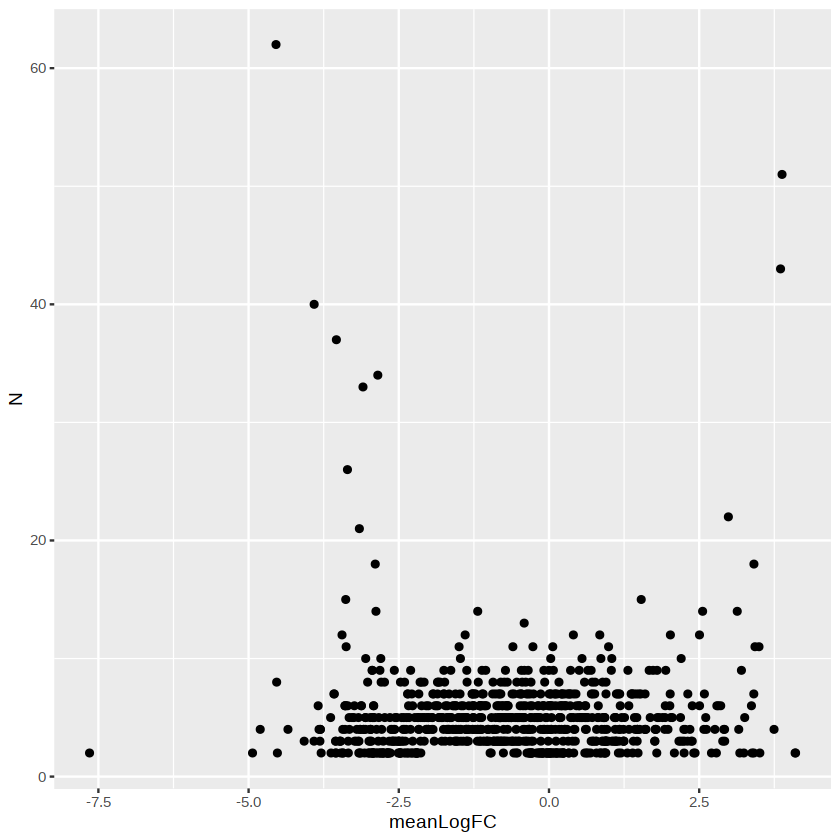

In [128]:
ggplot(de.stats[N>1], aes(meanLogFC, N)) + geom_point()